In [1]:
import os
os.chdir('../..')
import numpy as np
import torch
import pickle
from tqdm import tqdm
from rdkit.Chem import MolFromInchi
from rdkit.Chem.rdmolops import Kekulize

RDKit WARNING: [14:03:23] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
from molgrad.utils import DATA_PATH, EXAMPLE_PATH, MODELS_PATH
from molgrad.vis import molecule_importance
from molgrad.net import MPNNPredictor
from molgrad.train import DEVICE

os.makedirs(EXAMPLE_PATH, exist_ok=True)

Using backend: pytorch


In [4]:
with open(os.path.join(DATA_PATH, 'cyp', 'data_cyp.pt'), 'rb') as handle:
    inchis, values = pickle.load(handle)


with open(os.path.join(DATA_PATH, 'cyp', 'sim_cyp.pt'), 'rb') as handle:
    sim = pickle.load(handle)

preds = np.load(os.path.join(DATA_PATH, 'cyp', 'preds.npy'))
diff_true = np.load(os.path.join(DATA_PATH, 'cyp', 'diff_exp.npy'))
diff_hat = np.load(os.path.join(DATA_PATH, 'cyp', 'diff_hat.npy'))

In [5]:
ligand_i = []
ligand_j = []
values_i = []
values_j = []
preds_i = []
preds_j = []

long_sim = []
long_true = []
long_hat = []

for idx_i, (inchi_i, exp_i, pred_i) in enumerate(zip(inchis, values, preds)):
    for idx_j, (inchi_j, exp_j, pred_j) in enumerate(zip(inchis, values, preds)):
        if idx_i < idx_j:
            ligand_i.append(inchi_i)
            ligand_j.append(inchi_j)
            values_i.append(exp_i)
            values_j.append(exp_j)
            preds_i.append(pred_i)
            preds_j.append(pred_j)
            long_sim.append(sim[idx_i, idx_j])
            long_true.append(diff_true[idx_i, idx_j])
            long_hat.append(diff_hat[idx_i, idx_j])

In [6]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

df_pairs = pd.DataFrame({'inchi_i': ligand_i,
                         'inchi_j': ligand_j,
                         'values_i': values_i,
                         'values_j': values_j,
                         'preds_i': preds_i,
                         'preds_j': preds_j,
                         'similarity': long_sim,
                         'diff_exp': long_true,
                         'diff_pred': long_hat})


In [7]:
def sali_index(sim, diff):
    return np.abs(diff) / (1 - sim)

In [8]:
df_pairs = df_pairs.loc[df_pairs['similarity'] < 1.0]
df_pairs['sali_exp'] = sali_index(df_pairs['similarity'], df_pairs['diff_exp'])
df_pairs['sali_pred'] = sali_index(df_pairs['similarity'], df_pairs['diff_pred'])
df_pairs.sort_values('sali_pred', ascending=False, inplace=True)
df_pairs.reset_index(inplace=True)

In [9]:
df_pairs.head(n=400)

,index,inchi_i,inchi_j,values_i,values_j,preds_i,preds_j,similarity,diff_exp,diff_pred,sali_exp,sali_pred
0,38973227,InChI=1S/C21H23N5OS/c1-2-3-6-11-26-19(22)17(21...,InChI=1S/C20H21N5OS/c1-2-3-10-25-18(21)16(20(2...,1.0,0.0,9.994618e-01,4.502248e-03,0.939024,1.0,0.994960,16.400000,16.317337
1,30208575,InChI=1S/C22H17N5O3/c1-29-16-8-10-17(11-9-16)3...,InChI=1S/C22H17N5O3/c1-29-16-10-8-15(9-11-16)1...,1.0,0.0,9.996772e-01,2.208178e-01,0.912088,1.0,0.778859,11.375001,8.859526
2,35508343,InChI=1S/C22H27N3O2/c1-3-25-22(27-4-2)19-14-13...,InChI=1S/C23H29N3O2/c1-3-16-26-23(28-4-2)20-14...,0.0,1.0,1.279658e-01,9.893556e-01,0.892857,-1.0,-0.861390,9.333333,8.039638
3,7234181,InChI=1S/C24H24F6N2O2/c1-34-20-5-3-2-4-16(20)1...,InChI=1S/C26H28F6N2O2/c1-36-22-6-3-2-5-18(22)1...,0.0,1.0,1.091546e-02,9.947336e-01,0.873786,-1.0,-0.983818,7.923076,7.794865
4,14304028,InChI=1S/C22H28N4O3/c1-16-19(17(2)29-24-16)20(...,InChI=1S/C21H26N4O3/c1-15-18(16(2)28-23-15)19(...,0.0,1.0,6.341212e-06,9.818108e-01,0.873563,-1.0,-0.981804,7.909092,7.765182
5,39603590,"InChI=1S/C24H21F6N3O/c25-23(26,27)19-9-18(10-2...","InChI=1S/C26H25F6N3O/c27-25(28,29)21-12-20(13-...",0.0,1.0,3.199289e-02,9.985911e-01,0.873786,-1.0,-0.966598,7.923076,7.658431
6,28515754,InChI=1S/C23H27N5O3/c1-16-20(17(2)31-26-16)21(...,InChI=1S/C22H25N5O3/c1-15-19(16(2)30-25-15)20(...,0.0,1.0,9.790087e-02,9.975308e-01,0.880435,-1.0,-0.899630,8.363638,7.524179
7,7238851,InChI=1S/C24H24F6N2O2/c1-34-20-5-3-2-4-16(20)1...,InChI=1S/C25H26F6N2O2/c1-35-21-6-3-2-5-17(21)1...,0.0,1.0,1.091546e-02,9.999261e-01,0.862745,-1.0,-0.989011,7.285715,7.205649
8,9648612,"InChI=1S/C23H23F6N3O/c24-22(25,26)17-12-16(13-...","InChI=1S/C21H19F6N3O/c22-20(23,24)15-9-14(10-1...",1.0,0.0,9.999179e-01,1.495863e-02,0.863158,1.0,0.984959,7.307691,7.197778
9,5070644,InChI=1S/C21H25F6N3O2/c1-13(2)28-18(32)30-7-5-...,InChI=1S/C20H23F6N3O2/c1-12(2)27-17(31)29-10-1...,1.0,0.0,9.977518e-01,4.244886e-02,0.866667,1.0,0.955303,7.500000,7.164772


In [51]:
model_pt = os.path.join(MODELS_PATH, 'cyp_noHs.pt')

from molgrad.net import MPNNPredictor

model = MPNNPredictor(node_in_feats=49,
                      edge_in_feats=10,
                      global_feats=4,
                      n_tasks=1,
                      output_f=torch.sigmoid).to(DEVICE) 
model.load_state_dict(torch.load(model_pt,
                                 map_location=DEVICE))

<All keys matched successfully>

In [52]:
inchi_i, inchi_j = df_pairs.loc[104, 'inchi_i'], df_pairs.loc[104, 'inchi_j'] # could show
mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)

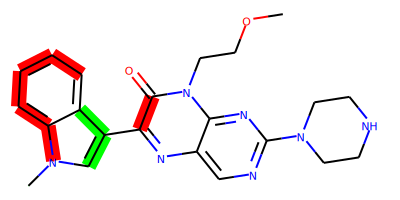

In [53]:
svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-3,
                                                      addHs=False)
img

In [54]:
with open(os.path.join(EXAMPLE_PATH, "cyp_cliff_one_pos.svg"), "w+") as handle:
    handle.write(svg)

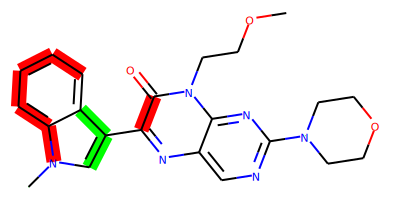

In [55]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-3,
                                                      addHs=False)
img

In [56]:
with open(os.path.join(EXAMPLE_PATH, "cyp_cliff_one_neg.svg"), "w+") as handle:
    handle.write(svg)

In [57]:
inchi_i, inchi_j = df_pairs.loc[233, 'inchi_i'], df_pairs.loc[233, 'inchi_j'] # nice example
mol_i, mol_j = MolFromInchi(inchi_i), MolFromInchi(inchi_j)

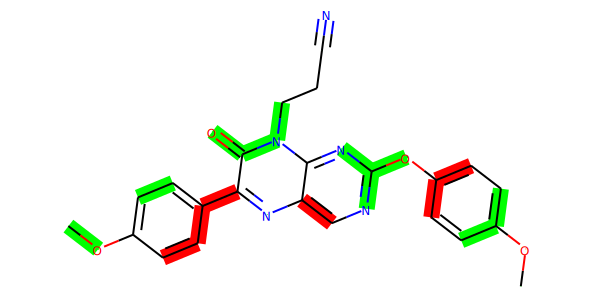

In [58]:
svg, img, _, _, global_importance = molecule_importance(mol_i,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-3,
                                                      addHs=False,
                                                      img_width=600,
                                                      img_height=300)
img

In [59]:
with open(os.path.join(EXAMPLE_PATH, "cyp_cliff_two_pos.svg"), "w+") as handle:
    handle.write(svg)

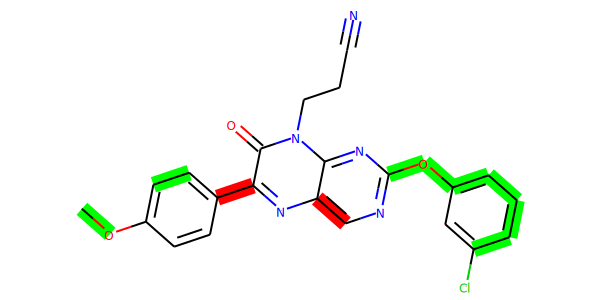

In [60]:
svg, img, _, _, global_importance = molecule_importance(mol_j,
                                                      model,
                                                      task=0,
                                                      version=2,
                                                      vis_factor=1,
                                                      eps=1e-3,
                                                      addHs=False,
                                                      img_width=600,
                                                      img_height=300)
img

In [61]:
with open(os.path.join(EXAMPLE_PATH, "cyp_cliff_two_neg.svg"), "w+") as handle:
    handle.write(svg)